# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Необходимо обучить модель, классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Построить модель со значением метрики качества *F1* не меньше 0.75.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержится текст комментария, а *toxic* — целевой признак.

**План работы:**

- Подготовка данных.
    - Обработка датасета: удаление ненужных столбцов, оптимизация типов данных;
    - Очистка текста: токкенизация, лемматизация, удаление стоп-слов и символов пунктуации;
- Обучение моделей.
  Будут использованы следующие модели для классификации:
    - LogisticRegression;
    - SGDClassifier;
    - LGBMClassifier.
- Обучаться модели будут двумя вариантами:
    - при помощи `TF-IDF` (`TfidfVectorizer`);
    - при помощи эмбеддингов `BERT`.
- Тестирование.
    - Предсказания и получение метрики для лучшей модели;
    - Матрица ошибок.
- Выводы.


## Подготовка данных

**Импорт необходимых библиотек.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
import re
import string
import os

import spacy
import spacy.lang.en
from spacy.lang.en import English
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression, SGDClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve

import torch
import transformers
from transformers import AutoModel, AutoTokenizer
from tqdm import notebook, tqdm
from pandarallel import pandarallel

from wordcloud import WordCloud
# from PIL import Image

import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

RANDOM = 42

**Загрузка датасета**

In [2]:
try:
    data = pd.read_csv("/datasets/toxic_comments.csv")
except FileNotFoundError:
    data = pd.read_csv(
        "https://code.s3.yandex.net/datasets/toxic_comments.csv")

**Информация по датасету.**

In [3]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Удаление столбца `Unnamed: 0`.

In [5]:
data = data.drop(['Unnamed: 0'], axis=1)

Функция для визуализации соотношения классов 0 и 1 в целевом столбце `toxic`.

In [6]:
def drow_target(column=None):
    '''
    Функция для визуализации соотношения классов 0 и 1 в целевом столбце toxic.

    Параметр:

     column: столбец с целевой переменной (пример: data['toxic']), по умолчанию None

    '''

    plt.figure(figsize=(12, 7))
    plt.title("Целевой признак", fontsize=18)

    ax = sns.barplot(x=column.unique(),
                     y=column.value_counts(normalize=True),
                     palette=['green', 'red'])

    for bar in ax.patches:
        ax.annotate(format(bar.get_height(), '.2f'),
                    (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    ha='center',
                    va='center',
                    size=16,
                    xytext=(0, 8),
                    textcoords='offset points',
                    rotation=0)

    plt.xlabel("Комментарии", fontsize=15)
    plt.ylabel("Процент токсичности", fontsize=15)
    plt.xticks(ticks=[0, 1], labels=['Нормальный', 'Токсичный'])

    plt.show()

Визуализация.

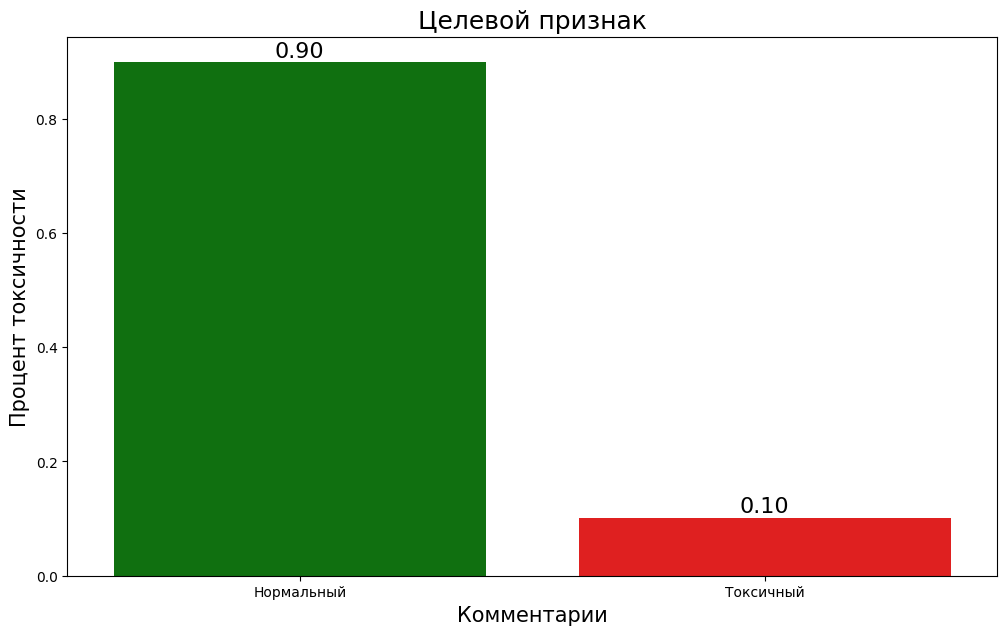

In [7]:
drow_target(column=data['toxic'])

Виден явный дисбаланс в сторону положительных комментариев 90% на 10%.

Т.к. исходный датасет достаточно большой и на локальной машине может может не хватить ресурсов придется его несколько сократить.

In [8]:
# количество строк в новом датасете
sample_size = 80000
# создание нового датасета
data_sample = data.sample(n=sample_size,
                          random_state=RANDOM).reset_index(drop=True)

print('Cоотношение классов в датасете:\n',
      data_sample['toxic'].value_counts() / data_sample.shape[0] * 100)

Cоотношение классов в датасете:
 0    89.92875
1    10.07125
Name: toxic, dtype: float64


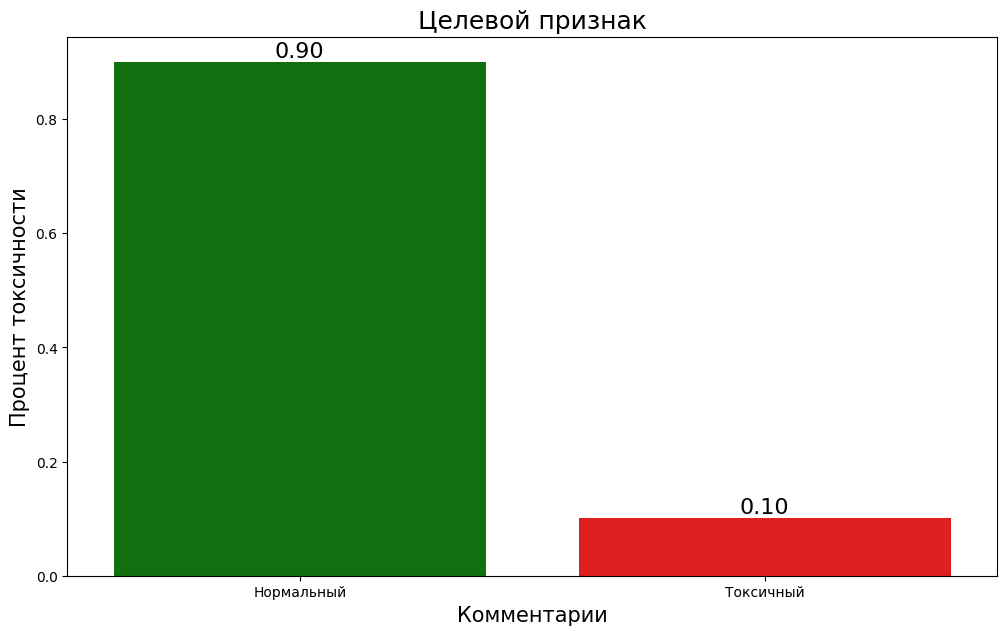

In [9]:
# визуализация соотношения классов 0 и 1 в новом датасете.
drow_target(column=data_sample['toxic'])

Целевой признак остался в том же соотношении: дисбаланс в сторону положительных комментариев 90% на 10%.

**Преобразование типов данных.**

In [10]:
# приведение столбца к более оптимальному типу int8, т.к. значений всего 2: 0 и 1
data_sample['toxic'] = data_sample['toxic'].astype('int8')
# перевод текстов в стандартный для Python формат: кодировку Unicode
data_sample['text'] = data_sample['text'].values.astype('U')

In [11]:
data_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    80000 non-null  object
 1   toxic   80000 non-null  int8  
dtypes: int8(1), object(1)
memory usage: 703.2+ KB


Типы данных оптимизированы.

**Spacy.**

Для токкенизации, лемматизации и удаления стоп-слов будет использована библиотека `Spacy`.

**Загрузка языковой модели `en_core_web_sm`.**

In [12]:
nlp = spacy.load("en_core_web_sm")

**Загрузка стопслов spacy**

In [13]:
stopwords = list(spacy.lang.en.stop_words.STOP_WORDS)

**Добавление стоп-слов из `sklearn`.**

In [14]:
STOPLIST = set(stopwords + list(sklearn_stop_words))

**Расширенный список пунктуационных символов для очистки текста при лемматизации.**

In [15]:
SYMBOLS = " ".join(string.punctuation).split(" ") + [
    "-", "...", "..", "”", "”", ". .", ". . .", ". . . ."
]

**Функция для очистки текста.**

In [16]:
def clear_text(text):
    '''
    Функция для очистки текста.

    Параметр:

     text: исходный текст для очистки.

    Вовращаемое значение:

     phrase: очищенный текст.

    '''

    # преобразование сокращений
    phrase = re.sub(r"’", "'", text)
    phrase = re.sub(r"\n", " ", phrase)
    phrase = re.sub(r"\t", " ", phrase)
    phrase = re.sub(r"\\", "", phrase)
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can't", "can not", phrase)
    phrase = re.sub(r"n't", " not", phrase)
    phrase = re.sub(r"'re", " are", phrase)
    phrase = re.sub(r"'s", " is", phrase)
    phrase = re.sub(r"'d", " would", phrase)
    phrase = re.sub(r"'ll", " will", phrase)
    phrase = re.sub(r"'ve", " have", phrase)
    phrase = re.sub(r"'m", " am", phrase)
    phrase = re.sub(r"ar", "are", phrase)

    # оставляем только символы и пунктуацию
    phrase = re.sub(r'[^a-zA-Z?.,!]', ' ', phrase)
    phrase = re.sub(r'[a-z]*[:.]+\S+', ' ', phrase)  # убираем ссылки
    # заменяем несколько пробелов на 1 пробел
    phrase = re.sub(r'([ ])\1+', ' ', phrase)
    phrase = phrase.lower()

    return phrase.strip()

**Функция для токкенизации, лемматизации, удаления стоп-слов и символов пунктуации.**

In [17]:
def lemm_stopwords(text):
    '''
    Функция для токкенизации, лемматизации, удаления стоп-слов и символов пунктуации.

    Параметр:

     text: очищенный текст.

    Вовращаемое значение:

     mytokens: леммы без стоп-слов и пунктуации в нижнем регистре.

    '''

    # создание токкенов
    mytokens = nlp(text)

    # лемматизачия токкена и перевод в нижний регистр
    mytokens = [
        word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_
        for word in mytokens
    ]

    # удаление стоп-слов, знаков пунктуации и возможных оставшихся цифр
    mytokens = " ".join([
        word for word in mytokens
        if word not in STOPLIST and word not in SYMBOLS and not word.isdigit()
    ])

    return mytokens.strip()

**Очистка текста.**

In [18]:
tqdm.pandas(desc="Очистка текста")
data_sample['clear_text'] = data_sample['text'].progress_apply(clear_text)

Очистка текста: 100%|██████████| 80000/80000 [00:10<00:00, 7306.11it/s] 


**Токкенизация, лемматизация, удаление стоп-слов и символов пунктуации.**

In [19]:
%%time
pandarallel.initialize(progress_bar=True)
data_sample['text_lemm'] = data_sample['clear_text'].parallel_apply(lemm_stopwords)

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


CPU times: user 20.2 s, sys: 1.82 s, total: 22 s
Wall time: 23min 36s


**Вывод результатов на примере одного комментария.**

In [20]:
print(f"Исходный текст (столбец 'text'):\n{data_sample['text'][0]}\n")
print(
    f"Очищенный текст (столбец 'clear_text'):\n{data_sample['clear_text'][0]}\n")
print(
    f"Лемматизированный текст (столбец 'text_lemm'):\n{data_sample['text_lemm'][0]}\n")

Исходный текст (столбец 'text'):
Sometime back, I just happened to log on to www.izoom.in with a friend’s reference and I was amazed to see the concept Fresh Ideas Entertainment has come up with. So many deals… all under one roof. This website is very user friendly and easy to use and is fun to be on.
You have Gossip, Games, Facts… Another exciting feature to add to it is Face of the Week… Every week, 4 new faces are selected and put up as izoom faces. It’s great to have been selected in four out of a group of millions. 
This new start up has already got many a deals in its kitty. Few of them being TheFortune Hotel, The Beach… are my personal favorites. izoom.in has a USP of mobile coupons. Coupons are available even when a user cannot access internet. You just need to SMS izoom support to 56767 and you get attended immediately.
All I can say is izoom.in is a must visit website for everyone before they go out for shopping or dining or for outing.
Cheers!!!

Очищенный текст (столбец 'cl

**Вывод.**

Данные подготовлены к обучению моделей.

**Облака слов для нормальных и токсичных комментариев.**

Выбрал максимум 100 слов для визуализации.

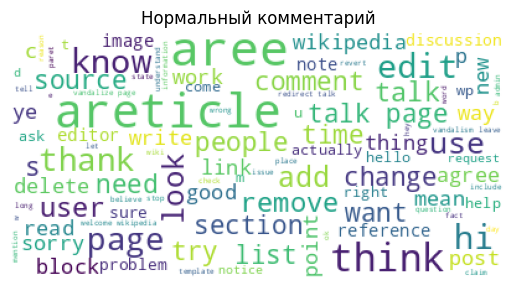

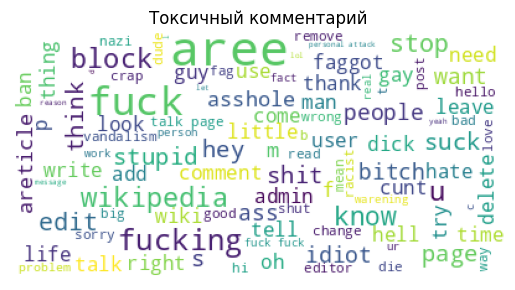

In [21]:
for x in data_sample['toxic'].unique():
    wc = WordCloud(background_color="white",
                   max_words=100,
                   max_font_size=40,
                   random_state=RANDOM)
    wc.generate(
        data_sample['text_lemm'].loc[(data_sample['text_lemm'].notnull()) &
                                     (data_sample['toxic'] == x)].to_string())
    plt.imshow(wc)
    if x == 0:
        plt.title('Нормальный комментарий')
    else:
        plt.title('Токсичный комментарий')
    plt.axis("off")
    plt.show()

Среди токсичных есть ненормативная лексика.

Генерация нескольких доп. признаков в датасет при помощи (`SentimentIntensityAnalyzer`)
    
Из составных значений `polarity_scores` добавлена 4 столца: `'neg'`, `'neu'`, `'pos'`.

In [22]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [23]:
sid = SentimentIntensityAnalyzer()

In [24]:
%%time
pandarallel.initialize(progress_bar=True)
data_sample['scores'] = data_sample['clear_text'].parallel_apply(lambda x: sid.polarity_scores(x))

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


CPU times: user 1.04 s, sys: 192 ms, total: 1.23 s
Wall time: 1min 4s


In [25]:
data_sample = data_sample.join(pd.json_normalize(data_sample.pop('scores')))
data_sample = data_sample.drop(['compound'], axis=1)

In [26]:
data_sample.sample(3)

,text,toxic,clear_text,text_lemm,neg,neu,pos
69010,I am not sure about the legality of fake copyr...,0,i am not sure about the legality of fake copyr...,sure legality fake copyright tag cleare prank ...,0.103,0.819,0.078
18287,"""op-eds are worthless sources when they don't ...",0,op eds aree worthless sources when they do not...,op ed aree worthless source work chriso narera...,0.050,0.923,0.027
4030,"""==Comment==\nThis article is a very poor adve...",0,comment this areticle is a very poor advertise...,comment areticle poor advertisement technologi...,0.043,0.875,0.082


## Обучение

В обучении будут использованы следующие модели для классификации:

- LogisticRegression;
- SGDClassifier;
- LGBMClassifier.

Обучаться модели будут двумя вариантами:

- при помощи `TF-IDF` (`TfidfVectorizer`);
- при помощи эмбеддингов `BERT`.

Будет использован перебор по сетке гиперпараметров при помощи `GridSearchCV` с кроссвалидацией `StratifiedKFold`.

Дисбаланс классов будет регулироваться параметром `class_weight='balanced'` для всех моделей.

Результы полученной метрики `F1`, будут сведены в единую таблицу и будет выбрана лучшая модель для проверки на тестовой выборке.

### TF-IDF

**Выделение признаков и целевого признака.**

Для признаков у нас один столбец с очищенным и лемматизированным текстом `text_lemm`.

Целевой признак столбец `toxic`.

In [27]:
features = data_sample[['text_lemm', 'neg', 'neu', 'pos']]
target = data_sample['toxic']

In [28]:
# числовые столбцы для StandardScaler()
numeric = ['neg', 'neu', 'pos']

**Разбиение датасета на трейн и тест в соотношении 80% на 20%.**

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target, random_state=RANDOM)

**Параметр для кроссвалидации.**

In [30]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM)

#### Модель LogisticRegression

**Пайплайн и сетка гиперпараметров.**

In [31]:
transformer = ColumnTransformer(
    [("scaler", StandardScaler(), numeric),
     ('tfidf', TfidfVectorizer(
         ngram_range=(1, 2), max_df=0.8), 'text_lemm')
     ])

In [32]:
log_ppl_clf = Pipeline([('tranformer', transformer),
                        ('log_clf',
                         LogisticRegression(tol=0.001,
                                            max_iter=10000,
                                            class_weight='balanced',
                                            penalty='l2',
                                            random_state=RANDOM))])

parameters_log = {
    'log_clf__solver': ['lbfgs', 'liblinear'],
    'log_clf__C': [1, 10, 100]
}

**Обучение модели.**

In [33]:
model_log = GridSearchCV(log_ppl_clf, parameters_log,
                         scoring='f1', cv=cv, n_jobs=-1).fit(X_train, y_train)
print('Модель обучена!')

Модель обучена!


**Результат.**

In [34]:
print('Метрика F1 на трейне с кроссвалидацией и лучшие параметры:\n')
print(
    f'F1: {model_log.best_score_:.4f}\nЛучшие параметры: {model_log.best_params_}'
)

Метрика F1 на трейне с кроссвалидацией и лучшие параметры:

F1: 0.7681
Лучшие параметры: {'log_clf__C': 100, 'log_clf__solver': 'liblinear'}


#### Модель SGDClassifier

**Пайплайн и сетка гиперпараметров.**

In [35]:
sgd_ppl_clf = Pipeline([('tranformer', transformer),
                        ('sgd_clf',
                         SGDClassifier(class_weight='balanced',
                                       random_state=RANDOM))])

parameters_sgd = {
    'sgd_clf__loss': ['hinge', 'log_loss'],
    'sgd_clf__penalty': ['l2', 'elasticnet']
}

**Обучение модели.**

In [36]:
model_sgd = GridSearchCV(sgd_ppl_clf,
                         parameters_sgd,
                         scoring='f1',
                         cv=cv,
                         n_jobs=-1).fit(X_train, y_train)
print('Модель обучена!')

Модель обучена!


**Результат.**

In [37]:
print('Метрика F1 на трейне с кроссвалидацией и лучшие параметры:\n')
print(
    f'F1: {model_sgd.best_score_:.4f}\nЛучшие параметры: {model_sgd.best_params_}'
)

Метрика F1 на трейне с кроссвалидацией и лучшие параметры:

F1: 0.6871
Лучшие параметры: {'sgd_clf__loss': 'hinge', 'sgd_clf__penalty': 'l2'}


#### Модель LGBMClassifier

**Пайплайн и сетка гиперпараметров.**

In [38]:
lgbm_ppl_clf = Pipeline([('tranformer', transformer),
                         ('lgbm_clf',
                          LGBMClassifier(objective='',
                                         class_weight='balanced',
                                         random_state=RANDOM))])

parameters_lgbm = {
    'lgbm_clf__max_depth': [9, 13, 15],
    'lgbm_clf__learning_rate': [0.01, 0.05, 0.1]
}

**Обучение модели.**

In [39]:
model_lgbm = GridSearchCV(lgbm_ppl_clf,
                          parameters_lgbm,
                          scoring='f1',
                          cv=cv,
                          n_jobs=1).fit(X_train, y_train)
print('Модель обучена!')

Модель обучена!


**Результат.**

In [40]:
print('Метрика F1 на трейне с кроссвалидацией и лучшие параметры:\n')
print(
    f'F1: {model_lgbm.best_score_:.4f}\nЛучшие параметры: {model_lgbm.best_params_}'
)

Метрика F1 на трейне с кроссвалидацией и лучшие параметры:

F1: 0.6117
Лучшие параметры: {'lgbm_clf__learning_rate': 0.1, 'lgbm_clf__max_depth': 15}


### Bert. AutoModel - `unitary/toxic-bert`

Вычисления будут производится на GPU.

In [41]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

**Загрузка предобученной модели AutoModel.**

In [42]:
model_class, tokenizer_class, pretrained_weights = (
    AutoModel, AutoTokenizer, 'unitary/toxic-bert')

**Инициализируем токенизатор как объект класса `AutoTokenizer()`.**

In [43]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

**Инициализируем модель как объект класса `AutoModel()`.**

In [44]:
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Преобразование текста в номера токенов из словаря методом `encode()`.**

Для корректной работы модели указан аргумент `add_special_tokens`, равный `True`. Это значит, что к любому преобразуемому тексту добавляется токен начала (101) и токен конца текста (102).

Также устанавливаем `truncation=True`, чтобы исключить токены, превышающие `max_length`.

In [45]:
tqdm.pandas(desc="Токкенизация DistilBert")
tokenized = data_sample['clear_text'].progress_apply(
    lambda x: tokenizer.encode(
        x, add_special_tokens=True, max_length=512, truncation=True))

Токкенизация DistilBert: 100%|██████████| 80000/80000 [00:33<00:00, 2402.40it/s]


Применим метод `padding`, чтобы после токенизации длины исходных текстов в корпусе были равными и поясним модели, что нули не несут значимой информации. Это нужно для компоненты модели, которая называется «внимание». Отбросим эти токены и «создадим маску» для действительно важных токенов, то есть укажем нулевые и не нулевые значения

In [46]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

In [47]:
padded = np.array([i + [0] * (max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

**Размер батча.**

In [48]:
batch_size = 100

**Цикл по батчам.**

In [49]:
embeddings = []

model.to(device)

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size * i:batch_size * (i + 1)])
    attention_mask_batch = torch.LongTensor(
        attention_mask[batch_size * i:batch_size * (i + 1)])

    with torch.no_grad():
        batch_embeddings = model(
            batch.to(device), attention_mask=attention_mask_batch.to(device))

    embeddings.append(batch_embeddings[0][:, 0, :].cpu().numpy())

  0%|          | 0/800 [00:00<?, ?it/s]

Время создания эмбеддингов: 45 минут на GPU 16 GB. ✅

**Сбор эмбеддингов в матрицу признаков вызовом функции concatenate().**

In [50]:
features = np.concatenate(embeddings)
target = data_sample['toxic']

**Разбиение на трейн и тест в соотношении 80% на 20%.**

In [51]:
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    features, target, test_size=.2, stratify=target, random_state=RANDOM)

#### Модель LogisticRegression

**Инициализация модели.**

In [52]:
model_log_bert = LogisticRegression(tol=0.001,
                                    max_iter=10000,
                                    class_weight='balanced',
                                    penalty='l2',
                                    random_state=RANDOM)

**Сетка гиперпараметров.**

In [53]:
parameters_log_bert = {
            'solver': ['lbfgs', 'liblinear'],
            'C': [1, 10, 1000]
}

**Обучение модели.**

При обучении может всплыть вот такое предупреждение:

    huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
    To disable this warning, you can either:
        - Avoid using `tokenizers` before the fork if possible
        - Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
        
Его можно проигнорировать или убрать след. образом.

In [54]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [55]:
model_log_bert_final = GridSearchCV(model_log_bert,
                                    parameters_log_bert,
                                    scoring='f1',
                                    cv=cv,
                                    n_jobs=-1).fit(X_train_bert, y_train_bert)
print('Модель обучена!')

Модель обучена!


**Результат.**

In [56]:
print('Метрика F1 на трейне с кроссвалидацией и лучшие параметры:\n')
print(
    f'F1: {model_log_bert_final.best_score_:.4f}\nЛучшие параметры: {model_log_bert_final.best_params_}'
)

Метрика F1 на трейне с кроссвалидацией и лучшие параметры:

F1: 0.8909
Лучшие параметры: {'C': 1, 'solver': 'lbfgs'}


#### Модель SGDClassifier

**Инициализация модели.**

In [57]:
model_sgd_bert = SGDClassifier(class_weight='balanced', random_state=RANDOM)

**Сетка гиперпараметров.**

In [58]:
parameters_sgd_bert = {
    'loss': ['hinge', 'log_loss'],
    'penalty': ['l2', 'elasticnet']
}

**Обучение модели.**

In [59]:
model_sgd_bert_final = GridSearchCV(model_sgd_bert,
                                    parameters_sgd_bert,
                                    scoring='f1',
                                    cv=cv,
                                    n_jobs=-1).fit(X_train_bert, y_train_bert)
print('Модель обучена!')

Модель обучена!


**Результат.**

In [60]:
print('Метрика F1 на трейне с кроссвалидацией и лучшие параметры:\n')
print(
    f'F1: {model_sgd_bert_final.best_score_:.4f}\nЛучшие параметры: {model_sgd_bert_final.best_params_}'
)

Метрика F1 на трейне с кроссвалидацией и лучшие параметры:

F1: 0.8869
Лучшие параметры: {'loss': 'hinge', 'penalty': 'elasticnet'}


#### Модель LGBMClassifier

**Инициализация модели.**

In [61]:
model_lgbm_bert = LGBMClassifier(objective='binary',
                                 class_weight='balanced',
                                 random_state=RANDOM)

**Сетка гиперпараметров.**

In [62]:
parameters_lgbm_bert = {
    'max_depth': [9, 13, 15],
    'learning_rate': [0.01, 0.05, 0.1]
}

**Обучение модели.**

In [63]:
model_lgbm_bert_final = GridSearchCV(model_lgbm_bert,
                                     parameters_lgbm_bert,
                                     scoring='f1',
                                     cv=cv,
                                     n_jobs=1).fit(X_train_bert, y_train_bert)
print('Модель обучена!')

Модель обучена!


**Результат.**

In [64]:
print('Метрика F1 на трейне с кроссвалидацией и лучшие параметры:\n')
print(
    f'F1: {model_lgbm_bert_final.best_score_:.4f}\nЛучшие параметры: {model_lgbm_bert_final.best_params_}'
)

Метрика F1 на трейне с кроссвалидацией и лучшие параметры:

F1: 0.9143
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 15}


**Результирующая таблица с метриками.**

In [65]:
data_f1 = {
    'F1 после кроссвалидации (TF-IDF)': [
        round(model_log.best_score_, 4),
        round(model_sgd.best_score_, 4),
        round(model_lgbm.best_score_, 4)
    ],
    'F1 после кроссвалидации (AutoModel - unitary/toxic-bert)': [
        round(model_log_bert_final.best_score_, 4),
        round(model_sgd_bert_final.best_score_, 4),
        round(model_lgbm_bert_final.best_score_, 4)
    ]
}

data_result = pd.DataFrame(
    data_f1, index=['LogisticRegression', 'SGDClassifier', 'LGBMClassifier'])

data_result

,F1 после кроссвалидации (TF-IDF),F1 после кроссвалидации (AutoModel - unitary/toxic-bert)
LogisticRegression,0.7681,0.8909
SGDClassifier,0.6871,0.8869
LGBMClassifier,0.6117,0.9143


Лучший результат у модели **`LGBMClassifier (BERT)`**.

Значение метрики `F1` - **0.9143**.

In [66]:
best_model = model_lgbm_bert_final

## Тестирование лучшей модели

Для тестирования берем модель с лучшим показателем.

Это модель - **`LGBMClassifier (BERT)`**.

**Получение метрики и предсказанных значений на тестовой выборке.**

In [67]:
predicted = best_model.best_estimator_.predict(X_test_bert)

f1_test = round(f1_score(predicted, y_test_bert), 4)

print(f"Метрика F1 лучшей модели на тестовой выборке: {f1_test}")

Метрика F1 лучшей модели на тестовой выборке: 0.908


**График полноты и точности.**

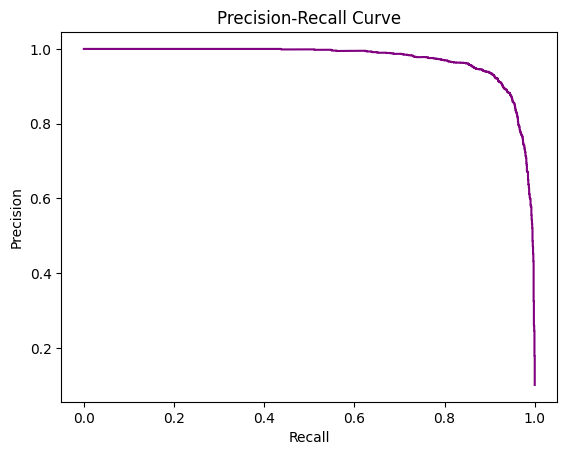

In [68]:
target_score = best_model.best_estimator_.predict_proba(X_test_bert)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test_bert,
                                                       target_score)


# create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

# add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

# display plot
plt.show()

**Матрица ошибок.**

In [69]:
conf_matrix = confusion_matrix(y_test_bert, predicted)

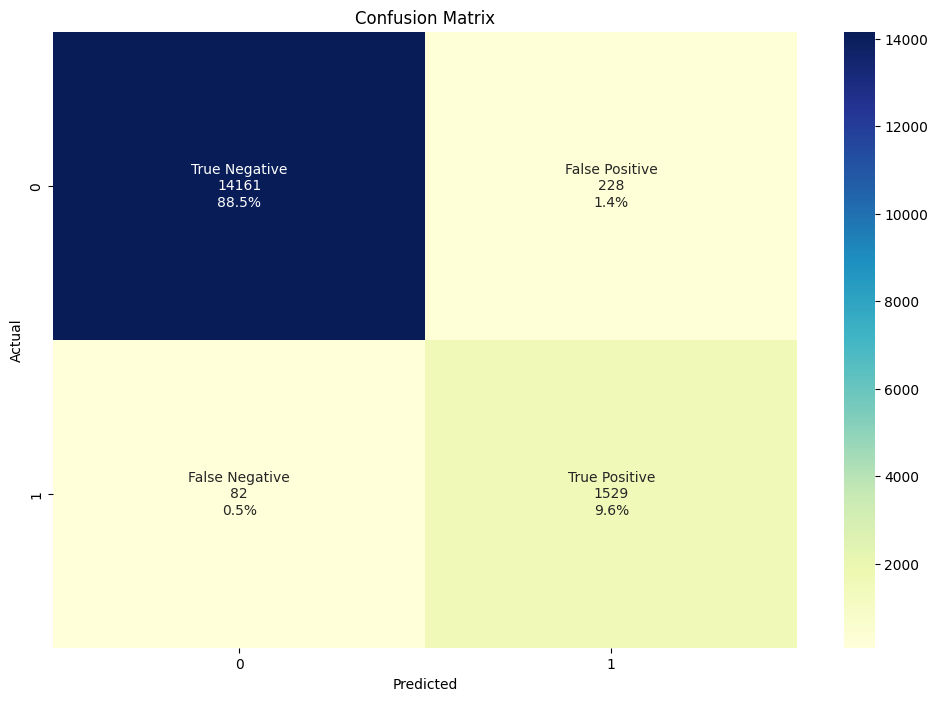

In [70]:
plt.figure(figsize=(12, 8))

classes = [
    "True Negative", "False Positive", "False Negative", "True Positive"
]

values = ["{0:0.0f}".format(x) for x in conf_matrix.flatten()]

percentages = [
    "{0:.1%}".format(x) for x in conf_matrix.flatten() / np.sum(conf_matrix)
]

combined = [f"{i}\n{j}\n{k}" for i, j, k in zip(classes, values, percentages)]
combined = np.asarray(combined).reshape(2, 2)

ax = sns.heatmap(conf_matrix, annot=combined, fmt="", cmap='YlGnBu')

ax.set(title='Confusion Matrix')
ax.set(xlabel='Predicted', ylabel='Actual')

plt.show()

In [71]:
TN = conf_matrix[0][0]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]
TP = conf_matrix[1][1]

total = TN + TP + FP + FN

acc = round((TP + TN) / total, 4)
recall = round(TP / (TP + FN), 4)
precision = round(TP / (TP + FP), 4)

print('Всего предсказаний:', total)
print(f'Правильно предсказанные ответы (Accuracy): {acc}')
print(f'Ошибки в прогнозах: {round(1 - acc, 4)}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1: {round(2 * (precision * recall) / (precision + recall), 4)}')

Всего предсказаний: 16000
Правильно предсказанные ответы (Accuracy): 0.9806
Ошибки в прогнозах: 0.0194
Recall: 0.9491
Precision: 0.8702
F1: 0.9079


Что в итоге:

1. По главной диагонали (от верхнего левого угла) выстроены правильные прогнозы:
   
   - **TN** в левом верхнем углу. 14161 правильных ответов. Статус нормального комментария соответствует истине.
   - **TP** в правом нижнем углу. 1529 правильных ответов. Статус токсичного комментария спрогнозирован верно.

2. Вне главной диагонали — ошибочные варианты:

   - **FP** в правом верхнем углу. 228 ошибок ошибочных предсказаний первого рода. Был нормальный комментарий - стал токсичный.
   - **FN** в левом нижнем углу. 82 ошибочных предсказаний второго рода. Был токсичный комментарий - стал нормальным.

## Выводы

В результате исследования были обучены три модели.

- LogisticRegression;
- SGDClassifier;
- LGBMClassifier.

Обучение было в двух вариантах:

- при помощи `TF-IDF` (`TfidfVectorizer`);
- при помощи эмбеддингов `BERT`.

Лучший результат у логистической регрессии (**`LGBMClassifier (BERT)`**.).

- `F1` на тренировочной выборке с кроссвалидацией : **0.9143**;
- `F1` на тестовой выборке : **0.9079**.

Метрика заявленная в условии достигнута.